In [45]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
import os
import graphviz

# Define the path to the Graphviz executable
graphviz_path = r"C:\Users\vgiddaluri\Graphviz\bin"
os.environ["PATH"] += os.pathsep + graphviz_path

# Verify if dot.exe exists in the specified path
dot_executable = os.path.join(graphviz_path, 'dot.exe')
if not os.path.isfile(dot_executable):
    raise FileNotFoundError(f"The file {dot_executable} does not exist. Please check the path.")

# Configure graphviz to use the specified executable
graphviz.set_default_engine('dot')
graphviz.set_default_format('pdf')

# Your existing code to generate the graph
dot = graphviz.Digraph(comment='The Round Table')
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')
dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')
print(dot.source)

// The Round Table
digraph {
	A [label="King Arthur"]
	B [label="Sir Bedevere the Wise"]
	L [label="Sir Lancelot the Brave"]
	A -> B
	A -> L
	B -> L [constraint=false]
}



In [47]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [48]:
#PYTORCH Code for backprogression analysis

class Value:

    def __init__(self, data, _children = (), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"value ={self.data}"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op="+")
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out.backward =_backward
        return out
    
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other),"-" )
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out.backward =_backward
        return out 
     
    def __mul__(self, other):
        out = Value((self.data * other.data), _children=(self, other), _op="*")
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out.backward = _backward
        return out 
    
    def __div__(self, other):
        out = Value(self.data / other.data, (self, other), "/")
        def _backward():        
            self.grad += out.grad/other.data
            other.grad += -out.grad*self.data/other.data**2
            out.backward =_backward
        return out
    
    def tanh(self):
        out = Value((math.exp(self.data) - math.exp(-self.data)) / (math.exp(self.data) + math.exp(-self.data)),(self,),"tanh")    
        def _backward():        
            self.grad += out.grad/ (1 - (out.data)**2)
            out.backward =_backward
        return out
 

In [49]:
   
#create a function that calls the list backwards
def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
        node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

value =-8.0

In [50]:
L.grad = 1
L.backward()
d.backward()
e.backward()

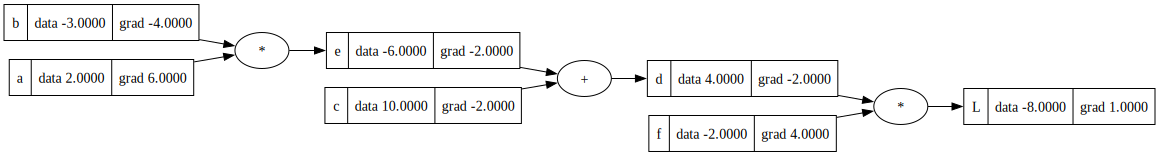

In [51]:
draw_dot(L)

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o

value =0.7071067811865477

In [9]:
class my_class:
    def __init__(self, x):
        self.val = x
    
    def __add__(self, other):
        return self.val + other.val
    
    def __mul__(self, other):
        return self.val * other.val

obj1 = my_class(5.0)
obj2 = my_class(6.0)
print(obj1+obj2)

11.0
